In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [ ]:
!pip install seaborn --upgrade

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf

import warnings
warnings.filterwarnings('ignore')

pd.options.display.float_format = '{:.1f}'.format  # 1 decimal only for float numbers display
np.set_printoptions(suppress=True)

In [2]:
sales = pd.read_csv("../input/competitive-data-science-predict-future-sales/sales_train.csv", parse_dates=['date'])
test = pd.read_csv("../input/competitive-data-science-predict-future-sales/test.csv")
items = pd.read_csv("../input/competitive-data-science-predict-future-sales/items.csv")
categories = pd.read_csv("../input/competitive-data-science-predict-future-sales/item_categories.csv")
shops = pd.read_csv("../input/competitive-data-science-predict-future-sales/shops.csv")

In [3]:
sales.head()

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day
0,2013-02-01,0,59,22154,999.0,1.0
1,2013-03-01,0,25,2552,899.0,1.0
2,2013-05-01,0,25,2552,899.0,-1.0
3,2013-06-01,0,25,2554,1709.0,1.0
4,2013-01-15,0,25,2555,1099.0,1.0


Here we make a join to join sales_train with shops, items and item categories DataFrames so we can get all the dsata we are looking for in the same DataFrame.

In [4]:
sales_train = sales.join(other=shops, on="shop_id", how="inner", rsuffix="_").join(items, on="item_id", how="inner", rsuffix="_").join(categories, on="item_category_id", how="inner", rsuffix="_")
sales_train.drop(['shop_id_', 'item_id_', 'item_category_id_'], axis=1, inplace=True)

## EDA

In [5]:
sales_train.head()

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day,shop_name,item_name,item_category_id,item_category_name
0,2013-02-01,0,59,22154,999.0,1.0,"Ярославль ТЦ ""Альтаир""",ЯВЛЕНИЕ 2012 (BD),37,Кино - Blu-Ray
25918,2013-02-01,0,25,22154,999.0,1.0,"Москва ТРК ""Атриум""",ЯВЛЕНИЕ 2012 (BD),37,Кино - Blu-Ray
25919,2013-03-01,0,25,22154,999.0,1.0,"Москва ТРК ""Атриум""",ЯВЛЕНИЕ 2012 (BD),37,Кино - Blu-Ray
25920,2013-01-20,0,25,22154,999.0,1.0,"Москва ТРК ""Атриум""",ЯВЛЕНИЕ 2012 (BD),37,Кино - Blu-Ray
25921,2013-01-23,0,25,22154,999.0,1.0,"Москва ТРК ""Атриум""",ЯВЛЕНИЕ 2012 (BD),37,Кино - Blu-Ray


In [6]:
sales_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2935849 entries, 0 to 2896865
Data columns (total 10 columns):
 #   Column              Dtype         
---  ------              -----         
 0   date                datetime64[ns]
 1   date_block_num      int64         
 2   shop_id             int64         
 3   item_id             int64         
 4   item_price          float64       
 5   item_cnt_day        float64       
 6   shop_name           object        
 7   item_name           object        
 8   item_category_id    int64         
 9   item_category_name  object        
dtypes: datetime64[ns](1), float64(2), int64(4), object(3)
memory usage: 246.4+ MB


In [7]:
sales_train.describe()

,date_block_num,shop_id,item_id,item_price,item_cnt_day,item_category_id
count,2935849.0,2935849.0,2935849.0,2935849.0,2935849.0,2935849.0
mean,14.6,33.0,10197.2,890.9,1.2,40.0
std,9.4,16.2,6324.3,1729.8,2.6,17.1
min,0.0,0.0,0.0,-1.0,-22.0,0.0
25%,7.0,22.0,4476.0,249.0,1.0,28.0
50%,14.0,31.0,9343.0,399.0,1.0,40.0
75%,23.0,47.0,15684.0,999.0,1.0,55.0
max,33.0,59.0,22169.0,307980.0,2169.0,83.0


In [8]:
len(sales_train[sales_train['item_cnt_day']< 0])

7356

Here we can observe that some item_cnt_day values are negative. It seems that when an item is returned to the shop by a customer, a new row is created with a negative count to compensate for adding the item count when the customer first bought it. For the moment, we will just remove those rows from the DataFrame.

In [9]:
sales_train = sales_train[(sales_train['item_cnt_day'] > 0) & (sales_train['item_price'] > 0)]
sales_train.isna().sum()

date                  0
date_block_num        0
shop_id               0
item_id               0
item_price            0
item_cnt_day          0
shop_name             0
item_name             0
item_category_id      0
item_category_name    0
dtype: int64

Here we want to remove item_cnt_day outliers from our data. We inspect the scatter plot and print somes percentiles to decide which threshold we should use to remove data.

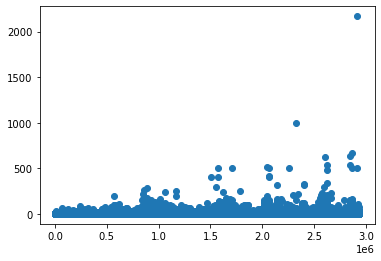

In [10]:
plt.scatter(sales_train.index, sales_train['item_cnt_day'])
plt.show()

### Percentile: 
It is a measure used in statistics indicating the value below which a given percentage of observations in a group of observations falls. For example the 20th percentile is the value (or score) below which 20% of the observation may be found.

In [11]:
p = 99
percentile= np.percentile(sales_train['item_cnt_day'], p)
print(f"The item_cnt_day {p}the percentile is equal to {percentile}")

The item_cnt_day 99the percentile is equal to 5.0


It means that 99% of item_cnt_day values are less or equal to 5 (so lies between 0 and 5)

In [12]:
outliers_num = len(sales_train[sales_train['item_cnt_day'] > percentile])
sales_train = sales_train[sales_train['item_cnt_day'] < percentile]
print(f"We removed {outliers_num} outliers from the data")

We removed 27411 outliers from the data


In [13]:
print(sales_train['item_id'].nunique())
print(sales_train['shop_id'].nunique())
print(len(test))

21794
60
214200


There is potentially 21807 x 60 (shop_id, item_id) combinations so 1 308 420 different combinations and that is pretty huge. Hopefully, we only need to forecast the combinations in the test file (214 200 combinations) and we also have to keep in mind that not all items are in all shops.

In [14]:
print(f"Min date from train set: {sales_train['date'].min().date()}")
print(f"Max date from train set: {sales_train['date'].max().date()}")

sales_train['month'] = sales_train['date'].dt.month
sales_train['year'] = sales_train['date'].dt.year

Min date from train set: 2013-01-01
Max date from train set: 2015-12-10


### What are the 15 most sold items?

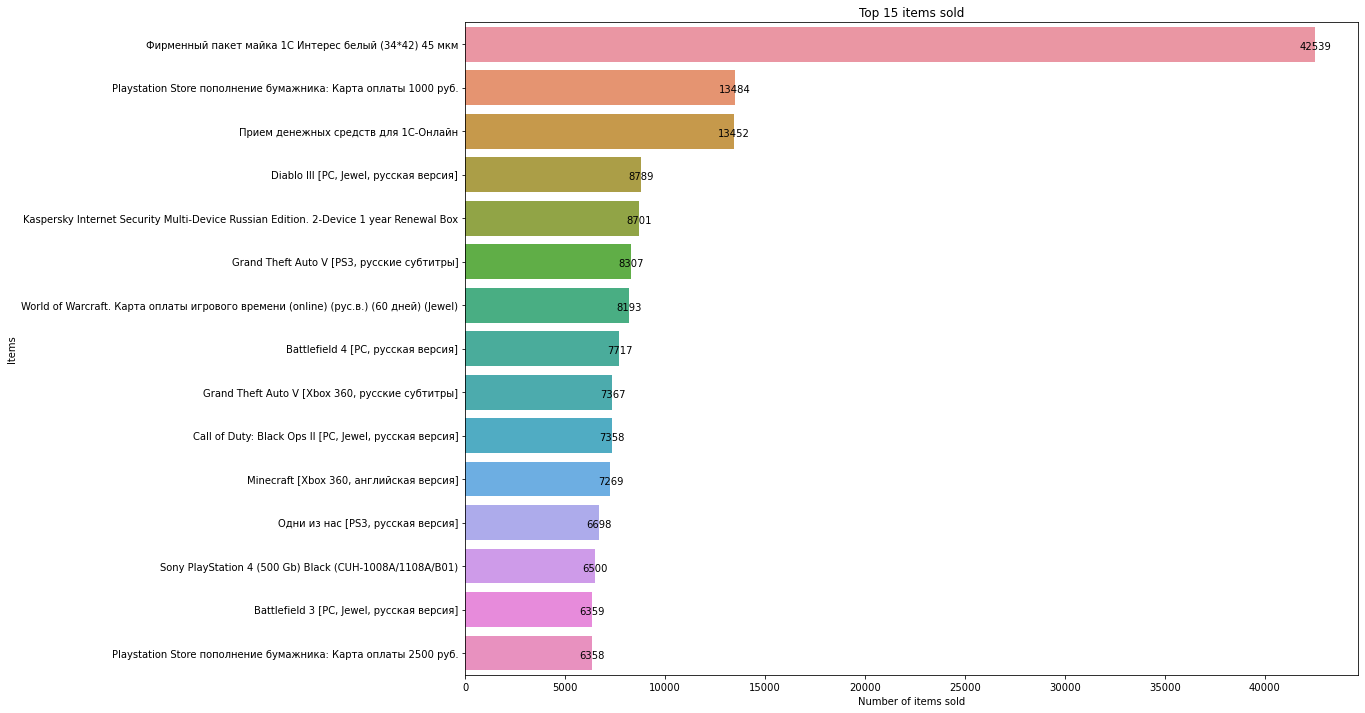

In [17]:
N = 15
items_total_sold = sales_train.groupby('item_id').sum()
items_total_sold.reset_index(inplace=True)

idxs = items_total_sold['item_cnt_day'].values.argsort()[::-1][0:N]
temp = items_total_sold['item_cnt_day'].to_numpy()
max_sold = [temp[idx] for idx in idxs]

item_ids = items_total_sold.loc[idxs,'item_id'].values
item_names = items.loc[item_ids, 'item_name']

fig, ax = plt.subplots(figsize=(16,12))
barplot = sns.barplot(x=max_sold, y=item_names)
for p in barplot.patches:
    barplot.text(p.get_width(), p.get_y()+0.55*p.get_height(), '{:1.0f}'.format(p.get_width()), ha='center', va='center')

barplot.set(xlabel='Number of items sold', ylabel='Items', title=f"Top {N} items sold")
plt.show()
    

Here we can observe that the most sold item is nothing but "Branded package T-shirt 1C interest white (34*42)" (using google traduction of course). It make sense, white t-shirt is a very basic cloth where for men or women that everyone should have their wardrobe. The rest of most sold items are video games such as Diablo III, a Massive online multiplayer game, Grand Theft Auto V (on 3 different platforms: PS3, Xbox360, PC) a famous RPG, Battlefield, an Online multiplayer game, and other many popular games. 1C is one of the largest video game development, publishing and distribution studios is Russia so it is not suprising that almost only video games are among the highest ranked.

### Shops ranking according to revenue

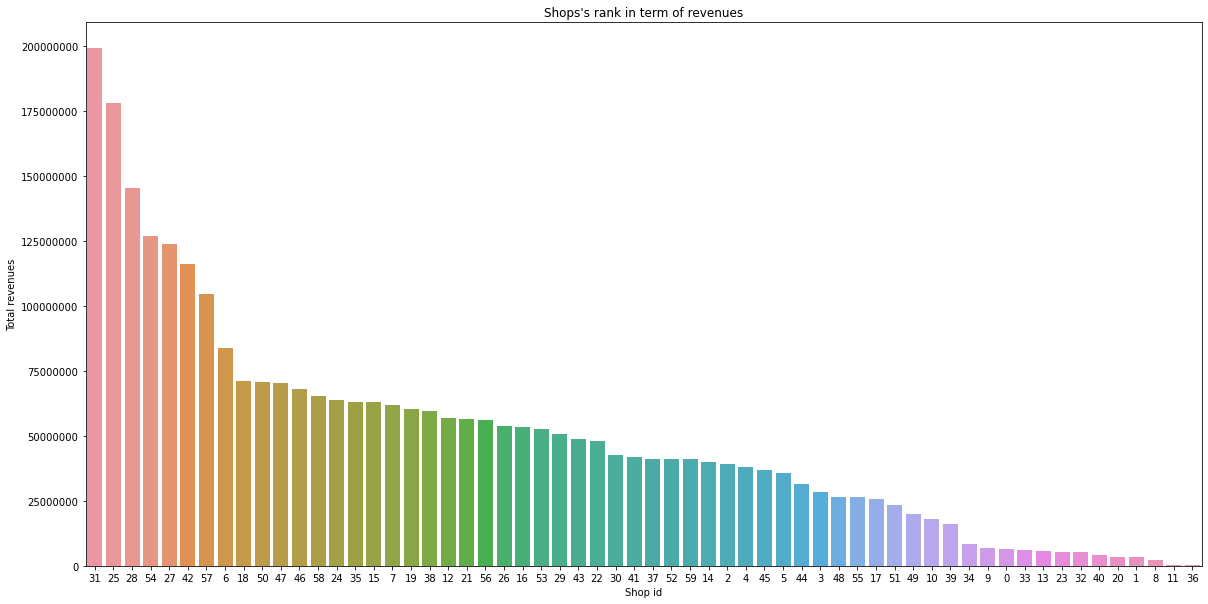

In [21]:
sales_train['transaction_price'] = sales_train['item_cnt_day'] * sales_train['item_price']
total_revenue_shops = sales_train.groupby('shop_id').agg({'transaction_price':['sum']})
total_shops = total_revenue_shops['transaction_price']['sum'].sort_values(ascending=False)
index = total_shops.index
# sns.set_theme(context="notebook", style="whitegrid", font_scale=1.3)

fig, ax = plt.subplots(figsize=(20,10))
barplot = sns.barplot(x=index, y=total_shops, order=index)
barplot.set(xlabel="Shop id", ylabel="Total revenues", title="Shops's rank in term of revenues")
plt.ticklabel_format(style='plain', axis='y')
plt.show()

### How sales behave globally?

In [22]:
avg_total_sales_day = sales_train.groupby('date').agg({'item_cnt_day' : ['sum']}).mean().values[0]
print(f"In average, total sales per day is about {round(avg_total_sales_day)} items sold")

In average, total sales per day is about 3132.0 items sold


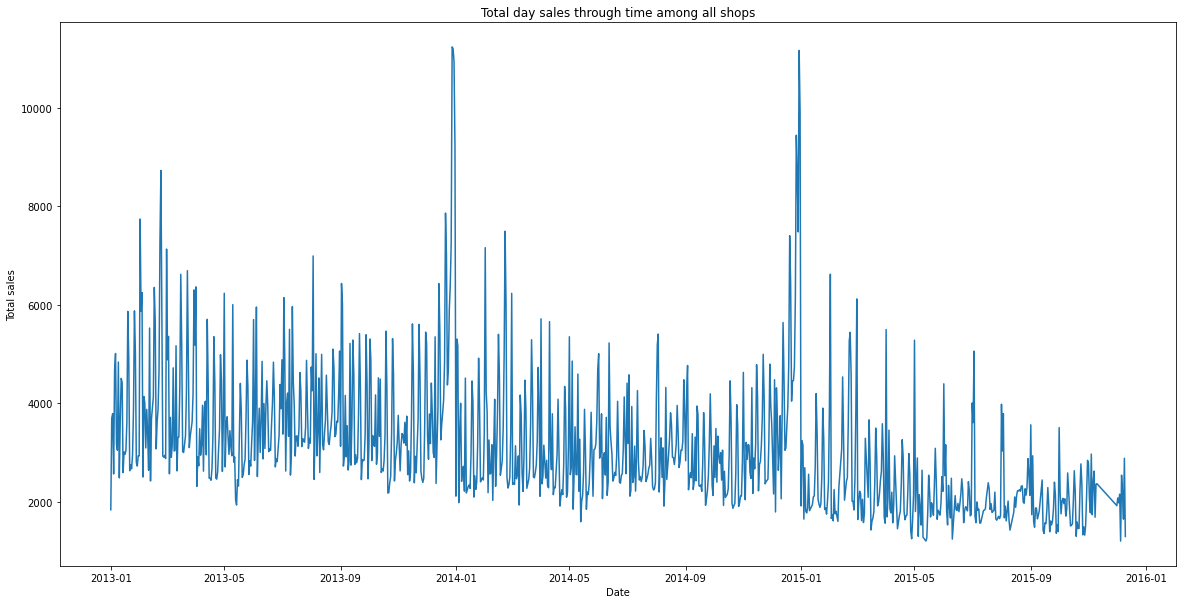

In [23]:
total_sales_day = sales_train.groupby('date').agg({'item_cnt_day': ['sum']})['item_cnt_day']['sum']

fig, ax = plt.subplots(figsize=(20,10))
lineplot = sns.lineplot(x=total_sales_day.index, y=total_sales_day)
lineplot.set(xlabel="Date", ylabel="Total sales", title="Total day sales through time among all shops")
plt.show()

We can notice that there is a seasonal pattern in total sales that seems to repeat each year. Indeed, there is a huge increase during november until late december of total sales (sales peaks). We can interpret this phenomenon as the increase of consumer purchases for  Christmas period and New Year celebration that could also be strengthen by discounts during this period. The highest peaks match with days just before New Year celebration which are in terms of total sales, approximatively 4 times higher than average.

In [24]:
avg_total_sales_month = sales_train.groupby(['year','month']).agg({'item_cnt_day': ['sum']}).mean().values[0]
print(f"In average, total sales per month is about {round(avg_total_sales_month)} items sold.")

In average, total sales per month is about 89960.0 items sold.


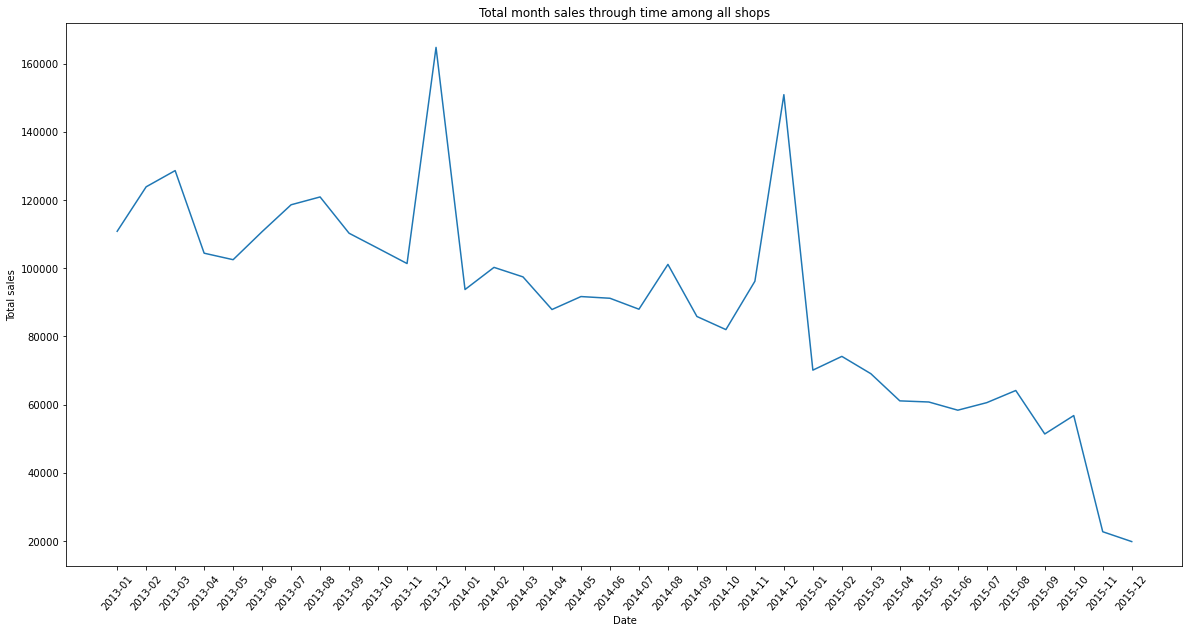

In [25]:
y = sales_train.groupby(['year','month']).agg({'item_cnt_day':['sum']})['item_cnt_day']['sum'].values

date =[]
years = ['2013','2014','2015']
for year in years:
    for month in range(1,13):
        if month < 10:
            date.append(year+'-0'+str(month))
        else:
            date.append(year+'-'+str(month))
            
fig, ax = plt.subplots(figsize=(20,10))
lineplot = sns.lineplot(x=date, y=y)
lineplot.set(xlabel="Date", ylabel="Total sales", title="Total month sales through time among all shops")
lineplot.set_xticklabels(date, rotation=50)
plt.show()

We can confirm the trends described earlier in this plot and also say that there is continued decline in total month sales over time. For instance, total month sales were about 12 000 items sold in january 2013, then went down to near 100 000 in january 2014 and finally only 80 000 in january 2015. A reason that could explain the general decrease is the fact that the list of shops and products slightly changes every month as written in the "Data" section of this kaggle project. Maybe some high-performance shops have left the list of shops or/and some polpular items have left the list of items.

Moreover, it seems like there is a huge drop in sales since october 2015 (going from 68000 to 28000 next month, almost a division of sales by a factor of 2.5 !). It is pretty unusual as this period is norally very conductive to sales as Christmas Eve approaches. That happened because of data missing between 2015-11-10 and 2015-12-01 (so 20 missing days of data) as suggested by the day sales plot. Maybe an error during cancatenation of data occured when building the datset.

To conclude, the trend in sales is clearly downwards.

In [26]:
sales_train.groupby('date').agg({'item_cnt_day': ['sum']}).tail(12)

,item_cnt_day
,sum
date,
2015-11-09,2355.0
2015-11-10,2364.0
2015-12-01,1918.0
2015-12-02,2075.0
2015-12-03,1975.0
2015-12-04,2152.0
2015-12-05,1198.0
2015-12-06,2538.0


### What are the 10 most popular categories?

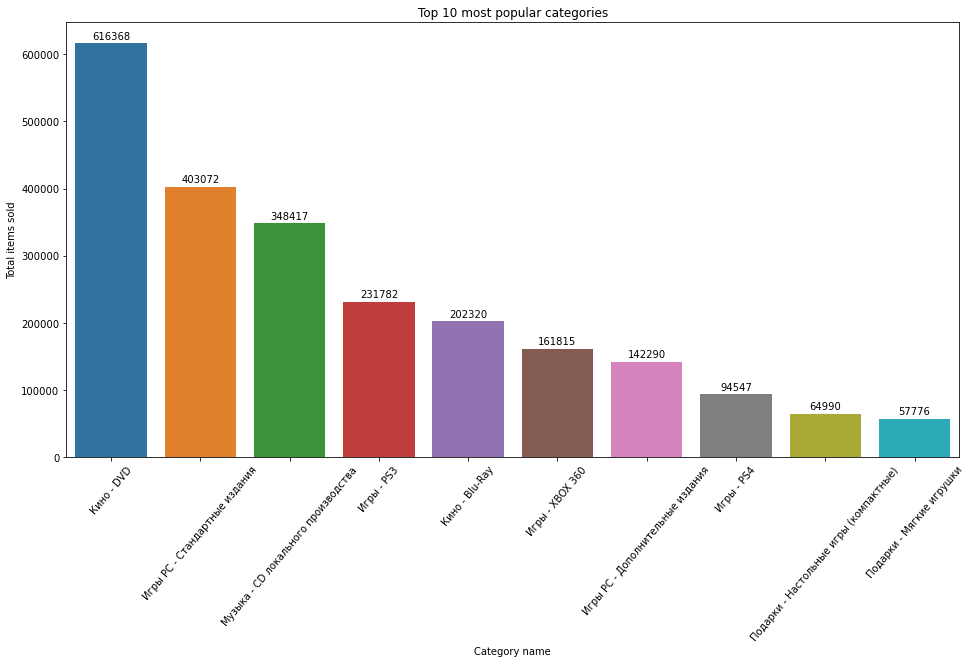

In [29]:
N = 10

total_categories_sold = sales_train.groupby('item_category_id').sum()
items_sold_by_category = total_categories_sold['item_cnt_day'].nlargest(n=N)
idxs = items_sold_by_category.index

categories_names=categories.loc[idxs, 'item_category_name']
fig, ax = plt.subplots(figsize=(16,8))
barplot = sns.barplot(x=categories_names, y=items_sold_by_category)
barplot.set(xlabel="Category name", ylabel="Total items sold", title=f"Top {N} most popular categories")
for label in barplot.get_xticklabels():
    label.set_rotation(50)
for p in barplot.patches:
    barplot.annotate(format(p.get_height(), '1.0f'), 
                    (p.get_x() + p.get_width() / 2., p.get_height()), 
                     ha='center', va='center', 
                     xytext=(0, 7), 
                     textcoords='offset points')
plt.ticklabel_format(style='plain', axis='y')
plt.show()

We can say from this plot that movies popularity is way ahead from the others categories with 616368 items sold in total. DVD quality (720x576 pixels resolution) is less good than Blu-Ray quality (1920 x 1080 pixels resolution) but it is still the most prefered category. It could be explained by multiple reasons including the price difference between those two categories (DVD is cheaper than blue ray), the fact that Blu-ray doesnot have a movie catalog as large as the DVDs (especially old titles) and also because there is still a significant part of russian families that do not have a full HD compatible TV to be able to play Blu-Ray movies.

Then we find PC games (standard and additional editions) as well as console games (PS3, XBOX 360, PS4 but not Xbox  One, Sony seems to have one the least generation of game console) and also music CD and albums.

### Preditions

#### Univariate LSTM Model

Let us build an univariate time series model that will be able to forecast the next month sales based on month sales sequences. We group data by month, shop_id, item_id and aggregrate by month using sum function. We then use pivot table to present data in an interpretable way (shop_id, item_id as index and month as columns).

In [30]:
data_sales = sales_train.groupby(['date_block_num', 'shop_id', 'item_id'], as_index= False)['item_cnt_day'].sum()
data_sales.rename(columns={'item_cnt_day': 'item_cnt_month'}, inplace=True)
data_sales = pd.pivot_table(data_sales, index=['shop_id','item_id'], columns=['date_block_num'], fill_value=0)

In [31]:
data_sales

item_cnt_month                              ...              \
date_block_num              0   1  2  3  4  5  6  7  8  9   ... 24 25 26 27   
shop_id item_id                                             ...               
0       30                   0  22  0  0  0  0  0  0  0  0  ...  0  0  0  0   
        31                   0  11  0  0  0  0  0  0  0  0  ...  0  0  0  0   
        32                   6  10  0  0  0  0  0  0  0  0  ...  0  0  0  0   
        33                   3   3  0  0  0  0  0  0  0  0  ...  0  0  0  0   
        35                   1  14  0  0  0  0  0  0  0  0  ...  0  0  0  0   
...                        ...  .. .. .. .. .. .. .. .. ..  ... .. .. .. ..   
59      22154                1   0  0  0  0  0  0  0  0  0  ...  0  0  0  0   
        22155                0   0  0  0  0  0  1  0  0  0  ...  0  0  0  0   
        22162                0   0  0  0  0  0  0  0  0  0  ...  0  9  4  1   
        22164                0   0  0  0  0  0  0  0  0  0  ...  0  2  1  2   
        22167                0   0  0  0  0  0  0  0  0  1  ...  0  0  0  0   

                                   
date_block_num  28 29 30 31 32 33  
shop_id item_id                    
0       30       0  0  0  0  0  0  
        31       0  0  0  0  0  0  
        32       0  0  0  0  0  0  
        33       0  0  0  0  0  0  
        35       0  0  0  0  0  0  
...             .. .. .. .. .. ..  
59      22154    0  0  0  0  0  0  
        22155    0  0  0  0  0  0  
        22162    1  0  0  1  0  0  
        22164    0  0  1  0  0  0  
        22167    0  0  0  0  0  0  

[423948 rows x 34 columns]

We must now merge the test dataset with our data DataFrame because we only need to predict the (shop_id, item_id) combinations contained in the test dataset.

In [32]:
df_sales = data_sales.merge(test, how='right', on=['shop_id', 'item_id'])
per = round(df_sales.isna().sum()[2] / len(df_sales), 2)
df_sales

,shop_id,item_id,"(item_cnt_month, 0)","(item_cnt_month, 1)","(item_cnt_month, 2)","(item_cnt_month, 3)","(item_cnt_month, 4)","(item_cnt_month, 5)","(item_cnt_month, 6)","(item_cnt_month, 7)",...,"(item_cnt_month, 25)","(item_cnt_month, 26)","(item_cnt_month, 27)","(item_cnt_month, 28)","(item_cnt_month, 29)","(item_cnt_month, 30)","(item_cnt_month, 31)","(item_cnt_month, 32)","(item_cnt_month, 33)",ID
0,5,5037,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,1.0,1.0,3.0,1.0,0.0,0
1,5,5320,nan,nan,nan,nan,nan,nan,nan,nan,...,nan,nan,nan,nan,nan,nan,nan,nan,nan,1
2,5,5233,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,3.0,2.0,0.0,1.0,3.0,1.0,2
3,5,5232,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,3
4,5,5268,nan,nan,nan,nan,nan,nan,nan,nan,...,nan,nan,nan,nan,nan,nan,nan,nan,nan,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
214195,45,18454,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,214195
214196,45,16188,nan,nan,nan,nan,nan,nan,nan,nan,...,nan,nan,nan,nan,nan,nan,nan,nan,nan,214196
214197,45,15757,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,214197
214198,45,19648,nan,nan,nan,nan,nan,nan,nan,nan,...,nan,nan,nan,nan,nan,nan,nan,nan,nan,214198


In [33]:
print(f"The percentage of (shop_id, item_id) combinations with NaN values is {per}")

The percentage of (shop_id, item_id) combinations with NaN values is 0.48


That is interesting as 48 percent of rows of our merged DataFrame are (shop_id, item_id) combinations which were not found in the data DataFrame (training set) so their item_cnt_month cells are full empty with NaN values. We must fill them with 0 as we can't do anything better right now. Intuitively, putting 0 sales for every (item_id shop_id) combination that isn't in training data means that every item not listed in a shop hasn't been sold.
We also delete shop_id, item_id and ID columns, they are not useful for our model. Indeed we want to create an LSTM model which will be feed on time series data, i.e. monthly sales for each combination.

In [34]:
df_sales.fillna(0, inplace=True)
df_sales.drop(['shop_id', 'item_id', 'ID'], axis=1, inplace=True)
df_sales.head()

,"(item_cnt_month, 0)","(item_cnt_month, 1)","(item_cnt_month, 2)","(item_cnt_month, 3)","(item_cnt_month, 4)","(item_cnt_month, 5)","(item_cnt_month, 6)","(item_cnt_month, 7)","(item_cnt_month, 8)","(item_cnt_month, 9)",...,"(item_cnt_month, 24)","(item_cnt_month, 25)","(item_cnt_month, 26)","(item_cnt_month, 27)","(item_cnt_month, 28)","(item_cnt_month, 29)","(item_cnt_month, 30)","(item_cnt_month, 31)","(item_cnt_month, 32)","(item_cnt_month, 33)"
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,2.0,0.0,0.0,0.0,1.0,1.0,1.0,3.0,1.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,3.0,2.0,0.0,1.0,3.0,1.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


We prepare our train/validation/test sets properly. Our splitting strategy is the following :

1. We train our time series model from 0 to 32 date_block_num (from January 2013 to September 2015) and try to predict 33 (October 2015 sales) in order to learn patterns from data.
2. To better evaluate the model's performance (at each epoch), we split our data between train and validation sets (90% training and 10% validation). We use validation MSE (Mean Square Error) metric to monitor performance during training.
3. We make predictions of November 2015 sales using our trained LSTM model with test set from 1 to 33 date_block_num (from February 2013 to October 2015).

Each sets must have the same dimensions (so same number of timesteps as we want to build an univariate model here, i.e features=1).

In [36]:
from sklearn.model_selection import train_test_split

X, y = df_sales.drop(labels=[('item_cnt_month',33)], axis=1).values, df_sales.values[:,-1]
X_test = df_sales.drop(labels=[('item_cnt_month',0)], axis=1).values

# We need to reshape the data accordingly to Keras input shape (bach_size, timesteps, features)
X = X.reshape(X.shape[0], X.shape[1], 1)
y = y.reshape(y.shape[0], 1)
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.10, shuffle=True, random_state=0)

print("X_train shape : ", X_train.shape)
print("y_train shape : ", y_train.shape)
print("X_val shape : ", X_val.shape)
print("y_val shape : ", y_val.shape)
print("X_test shape : ", X_test.shape)

X_train shape :  (192780, 33, 1)
y_train shape :  (192780, 1)
X_val shape :  (21420, 33, 1)
y_val shape :  (21420, 1)
X_test shape :  (214200, 33, 1)


In [37]:
from tensorflow.keras import Sequential, Input
from tensorflow.keras.layers import Dense, LSTM, Dropout
from tensorflow.keras.callbacks import EarlyStopping

tf.keras.backend.set_floatx('float64')
early_stopping = EarlyStopping(monitor='val_loss', patience=2, mode='auto')

def plot_train_val_curves(hist):
    fig, (ax1, ax2) = plt.subplots(2, figsize=(15,8), sharex=True)
    fig.suptitle('Loss and MSE train and validation curves')
    ax1.plot(hist.history['loss'], label='train')
    ax1.plot(hist.history['val_loss'], label='validation')
    ax1.set_xlabel("Epochs")
    ax1.set_ylabel("Loss")
    ax1.legend()
    ax2.plot(hist.history['mean_squared_error'], label='train')
    ax2.plot(hist.history['val_mean_squared_error'], label='validation')
    ax2.set_xlabel("Epochs")
    ax2.set_ylabel("MSE")
    ax2.legend()
    plt.show()

def LSTM_model(shape, units=[64,64], dropout=0.3):
    model = Sequential()
    model.add(Input(shape=shape, dtype='float64'))
    model.add(LSTM(units=units[0], activation='tanh', return_sequences=True))
    model.add(Dropout(dropout))
    model.add(LSTM(units=units[1], activation='tanh'))
    model.add(Dropout(dropout))
    model.add(Dense(1, activation=None, kernel_initializer=tf.initializers.zeros()))
    return model


In [ ]:
lstm_model = LSTM_model(shape=(X_train.shape[1],X_train.shape[2]), units=[128,128], dropout=0.4)
lstm_model.compile(optimizer="Adam", loss="mse", metrics=['mean_squared_error'])
lstm_model.summary()
history = lstm_model.fit(X_train, y_train, validation_data=(X_val, y_val), batch_size=4096, epochs=10, callbacks=[early_stopping])
lstm_model.save("lstm_model", overwrite=True)

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 33, 128)           66560     
_________________________________________________________________
dropout (Dropout)            (None, 33, 128)           0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 128)               131584    
_________________________________________________________________
dropout_1 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense (Dense)                (None, 1)                 129       
Total params: 198,273
Trainable params: 198,273
Non-trainable params: 0
_________________________________________________________________
Epoch 1/10
48/48 [==============================] - 274s 6s/step - loss: 1.1825 - mean_squared_error: 1.1825 - val_l

In [ ]:
plot_train_val_curves(history)

Why is validation loss and MSE a little bit lower than training loss and MSE ? At first look, that's counter intuitive but it is actually normal in this case when we think about it. Our LSTM architecture includes 2 dropout layers that are used during training loop but are NOT in validation loop (Keras default behavior). Regularization methods often sacrifice training accuracy to improve validation/testing accuracy. This fact can explain by itself why it gives more accurate predictions on validation data and so a lower loss. Another reason is that training loss is measured during each epoch while validation loss is measured after each epoch. Training loss is continually reported over the course of an entire epoch, however, validation metrics are computed over the validation set only once the current training epoch is completed. A third reason would be that training and validation distributions are different but that's not our case as we shuffled our data before splitting it.

We predict November 2015 sales using our trained model. We replace negative predictions by zero values (no sales) and large values by 20, in another words, we clip predictions between 0 and 20. As we have seen at the beginning of this notebook, the distribution of sales lies in this area (outliers are above)

In [ ]:
predictions = lstm_model.predict(X_test)
predictions = predictions.clip(0,20)

In [ ]:
per = round(predictions[predictions > 1].sum() / len(predictions), 2) * 100
print(f"{per} % of sales predictions are higher than 1")

Finally, we export submission DataFrame in csv file without writting the default index in it (ID column is already an index).

In [ ]:
test_submission = pd.DataFrame({'ID': test['ID'], 'item_cnt_month': predictions.flatten()})
test_submission.to_csv('test_submission.csv', index=False) 

### Multivariate LSTM model
This time, we are going to build a multivariate LSTM model by adding another important feature : item_price. We will aggregate monthly item_price using mean function. This feature will be a good indicator of the price variation and will help as a predictor to get more accurate forecast sales. We will use the same data processing stages that we used for the last model. We will get at the end 2 features for each timestep (1 timestep = 1 month) in our time series data.

In [ ]:
from sklearn.preprocessing import MinMaxScaler

# We scale item_price in our train and test set. This will stabilize training and make it faster.
scaler = MinMaxScaler()
sales_train['item_price'] = scaler.fit_transform(sales_train['item_price'].values.reshape(-1,1))

In [ ]:
data_prices = sales_train.groupby(['date_block_num', 'shop_id', 'item_id'], as_index=False)['item_price'].mean()
data_prices.rename(columns={'item_price': 'item_price_mean'}, inplace=True)
data_prices = pd.pivot_table(data_prices, index=['shop_id','item_id'], columns=['date_block_num'], fill_value=0)
data_prices

In [ ]:
df_prices = data_prices.merge(test, how="right", on=['shop_id','item_id']).fillna(0)
df_prices.drop(['shop_id', 'item_id', 'ID'], axis=1, inplace=True)

# get each feature for training data and labels 
X_sales = df_sales.drop(labels=[('item_cnt_month',33)], axis=1).values
X_prices = df_prices.drop(labels=[('item_price_mean',33)], axis=1).values
y = df_sales.values[:,-1]

# reshape arrays
X_sales = X_sales.reshape(X_sales.shape[0], X_sales.shape[1], 1)
X_prices = X_prices.reshape(X_prices.shape[0], X_prices.shape[1], 1)
# combine sales and prices in the same numpy array
X = np.append(X_sales, X_prices, axis=2)
y = y.reshape(y.shape[0], 1)

# construct test data (X_test)
X_sales_test = df_sales.drop(labels=[('item_cnt_month',0)], axis=1).values
X_prices_test = df_prices.drop(labels=[('item_price_mean',0)], axis=1).values
X_sales_test = X_sales_test.reshape(X_sales_test.shape[0], X_sales_test.shape[1], 1)
X_prices_test = X_prices_test.reshape(X_prices_test.shape[0], X_prices_test.shape[1], 1)
X_test = np.append(X_sales_test, X_prices_test, axis=2)

# split data in train and validation sets 
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.10, shuffle=True, random_state=0)

print("X shape : ", X.shape)
print("y shape : ", y.shape)
print("X_train shape : ", X_train.shape)
print("y_train shape : ", y_train.shape)
print("X_val shape : ", X_val.shape)
print("y_val shape : ", y_val.shape)
print("X_test shape : ", X_test.shape)

In [ ]:
mult_lstm_model = LSTM_model(shape=(X_train.shape[1],X_train.shape[2]), units=[128,128], dropout=0.4)
mult_lstm_model.compile(optimizer="Adam", loss="mse", metrics=['mean_squared_error'])
mult_lstm_model.summary()
history = mult_lstm_model.fit(X_train, y_train, validation_data=(X_val, y_val), batch_size=4096, epochs=10, callbacks=[early_stopping])
mult_lstm_model.save("mult_lstm_model", overwrite=True)

In [ ]:
plot_train_val_curves(history)

In [ ]:
predictions = mult_lstm_model.predict(X_test)
predictions = predictions.clip(0,20)
test_submission = pd.DataFrame({'ID': test['ID'], 'item_cnt_month': predictions.flatten()})
test_submission.to_csv('test_submission2.csv', index=False) 